In [1]:
import os

import matplotlib.pyplot as plt
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection

import utils

In [2]:
image_sets_path = '/mnt/data/DatasetsML/CV/VOC_2012/VOC2012/ImageSets/Main/'
train_path = os.path.join(image_sets_path, 'train.txt')
val_path = os.path.join(image_sets_path, 'val.txt')

images_path = '/mnt/data/DatasetsML/CV/VOC_2012/VOC2012/JPEGImages/'
annnots_path = '/mnt/data/DatasetsML/CV/VOC_2012/VOC2012/Annotations/'

In [3]:
train_images = utils.read_set(train_path)
val_images = utils.read_set(val_path)

set(train_images) & set(val_images)

print(f'train: {len(train_images)}')
print(f'val: {len(val_images)}')

train: 5717
val: 5823


In [4]:
def model_size(model):
    """
    Return model size in MB.
    """
    return sum(
        p.numel() * p.element_size()
        for p in model.parameters()
    ) / 1024**2


def model_params(model):
    return sum([p.numel() for p in model.parameters()])

In [5]:
from collections import namedtuple
from typing import List
from bs4 import BeautifulSoup, element


import numpy as np


Box = namedtuple('Box', 'xmin ymin xmax ymax')
VOCObject = namedtuple('VOCObject', 'cls xyxy')


def read_set(filepath: str) -> List[List[str]]:
    with open(filepath, 'r') as file:
        lines = file.readlines()
    return [line[:-1] for line in lines]


def read_xml(filepath: str) -> BeautifulSoup:
    with open(filepath, 'r') as xml_file:
        data = xml_file.read()
    return BeautifulSoup(data, 'xml')


def read_image_rgb(filepath: str) -> np.array:
    return cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)


def parse_box_xyxy(annot_obj: element.Tag) -> Box:
    return Box(
        int(annot_obj.xmin.string),
        int(annot_obj.ymin.string),
        int(annot_obj.xmax.string),
        int(annot_obj.ymax.string),
    )


def parse_objects(annot: BeautifulSoup) -> List[VOCObject]:
    return [
        VOCObject(obj.find('name').string, parse_box_xyxy(obj))
        for obj in annot.find_all('object')
    ]

In [6]:
coco_id2label = {
    0: 'N/A',
    1: 'person',
    10: 'traffic light',
    11: 'fire hydrant',
    12: 'street sign',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    2: 'bicycle',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    26: 'hat',
    27: 'backpack',
    28: 'umbrella',
    29: 'shoe',
    3: 'car',
    30: 'eye glasses',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    4: 'motorcycle',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    45: 'plate',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    5: 'airplane',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    6: 'bus',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    66: 'mirror',
    67: 'dining table',
    68: 'window',
    69: 'desk',
    7: 'train',
    70: 'toilet',
    71: 'door',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    8: 'truck',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    83: 'blender',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    9: 'boat',
    90: 'toothbrush'
}

coco_label2id = {v: k for k, v in coco_id2label.items()}

coco2voc = {
    'airplane': 'aeroplane',
    'bicycle': 'bicycle',
    'bird': 'bird',
    'boat': 'boat',
    'bottle': 'bottle',
    'bus': 'bus',
    'car': 'car',
    'cat': 'cat',
    'chair': 'chair',
    'cow': 'cow',
    'dining table': 'diningtable',
    'dog': 'dog',
    'horse': 'horse',
    'motorcycle': 'motorbike',
    'person': 'person',
    'potted plant': 'pottedplant',
    'sheep': 'sheep',
    'couch': 'sofa',
    'train': 'train',
    'tv': 'tvmonitor',
}

voc2coco = {v: k for k, v in coco2voc.items()}


voc2_id2label = {
    0: 'aeroplane',
    1: 'bicycle',
    2: 'bird',
    3: 'boat',
    4: 'bottle',
    5: 'bus',
    6: 'car',
    7: 'cat',
    8: 'chair',
    9: 'cow',
    10: 'diningtable',
    11: 'dog',
    12: 'horse',
    13: 'motorbike',
    14: 'person',
    15: 'pottedplant',
    16: 'sheep',
    17: 'sofa',
    18: 'train',
    19: 'tvmonitor',
}

voc2_label2id = {lbl: i  for i, lbl in voc2_id2label.items()}


def voc_objects2target(voc_objects: List[VOCObject]) -> dict:
    gt_boxes, gt_labels = zip(*[
        (list(voc_obj.xyxy), coco_label2id[voc2coco[voc_obj.cls]])
        for voc_obj in voc_objects
    ])
    return {
        'boxes': torch.tensor(gt_boxes).to(float),
        'labels': torch.tensor(gt_labels)
    }

# Model

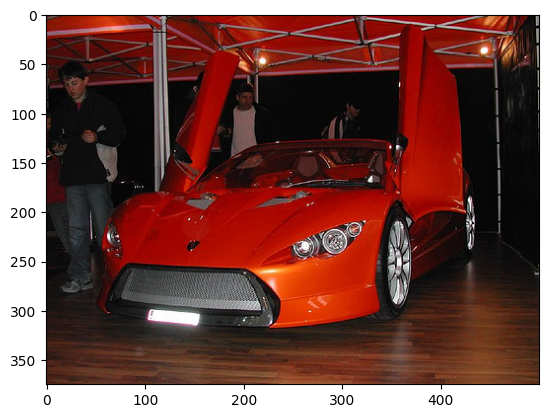

In [7]:
img_i = 238
img_p = os.path.join(images_path, f'{train_images[img_i]}.jpg')
annot_p = os.path.join(annnots_path, f'{train_images[img_i]}.xml')

val_img = utils.read_image_rgb(img_p)
plt.imshow(val_img);

In [8]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a Ber

In [9]:
inputs = processor(images=val_img, return_tensors="pt")
targets = [voc_objects2target(parse_objects(read_xml(annot_p)))]

In [10]:
import torchvision
from torch import nn, Tensor, optim
from torchvision.models._utils import IntermediateLayerGetter
from typing import Optional, Callable
import lightning.pytorch as pl
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights as frcnn_w
import cv2


class FrozenBatchNorm2d(torch.nn.Module):
    """
    BatchNorm2d where the batch statistics and the affine parameters are fixed.

    Copy-paste from torchvision.misc.ops with added eps before rqsrt,
    without which any other models than torchvision.models.resnet[18,34,50,101]
    produce nans.
    """

    def __init__(self, n):
        super(FrozenBatchNorm2d, self).__init__()
        self.register_buffer("weight", torch.ones(n))
        self.register_buffer("bias", torch.zeros(n))
        self.register_buffer("running_mean", torch.zeros(n))
        self.register_buffer("running_var", torch.ones(n))

    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict,
                              missing_keys, unexpected_keys, error_msgs):
        num_batches_tracked_key = prefix + 'num_batches_tracked'
        if num_batches_tracked_key in state_dict:
            del state_dict[num_batches_tracked_key]

        super(FrozenBatchNorm2d, self)._load_from_state_dict(
            state_dict, prefix, local_metadata, strict,
            missing_keys, unexpected_keys, error_msgs)

    def forward(self, x):
        # move reshapes to the beginning
        # to make it fuser-friendly
        w = self.weight.reshape(1, -1, 1, 1)
        b = self.bias.reshape(1, -1, 1, 1)
        rv = self.running_var.reshape(1, -1, 1, 1)
        rm = self.running_mean.reshape(1, -1, 1, 1)
        eps = 1e-5
        scale = w * (rv + eps).rsqrt()
        bias = b - rm * scale
        return x * scale + bias


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [11]:
class ResnetFasterRCNN(nn.Module):
    def __init__(self, resnet_name: str):
        super().__init__()
        self.resnet_name = resnet_name
        self.fasterrcnn = None
        self._init_model()
        self._freeze_params()

    def _init_model(self):
        self.fasterrcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(frcnn_w.COCO_V1)
        resnet = getattr(torchvision.models, self.resnet_name)(
            replace_stride_with_dilation=[False, False, False],
            pretrained=True,
            norm_layer=FrozenBatchNorm2d,
        )
        if self.resnet_name == 'resnet18':
            # layer1
            resnet.layer1[1] = BasicBlock(
                inplanes=64,
                planes=256,
                stride=1,
                downsample=nn.Sequential(
                    nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
                    FrozenBatchNorm2d(256),
                ),
                norm_layer=FrozenBatchNorm2d,
            )
            resnet.layer1[1].conv1 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            resnet.layer1[1].conv2 = nn.Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            # layer2
            resnet.layer2[0] = BasicBlock(
                inplanes=256,
                planes=128,
                stride=2,
                downsample=nn.Sequential(
                    nn.Conv2d(256, 128, kernel_size=(1, 1), stride=(2, 2), bias=False),
                    FrozenBatchNorm2d(128),
                ),
                norm_layer=FrozenBatchNorm2d,
            )
            resnet.layer2[0].conv1 = nn.Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            resnet.layer2[0].conv2 = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            resnet.layer2[1] = BasicBlock(
                inplanes=128,
                planes=512,
                stride=1,
                downsample=nn.Sequential(
                    nn.Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False),
                    FrozenBatchNorm2d(512),
                ),
                norm_layer=FrozenBatchNorm2d,
            )
            resnet.layer2[1].conv1 = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            resnet.layer2[1].bn1 = FrozenBatchNorm2d(128)
            resnet.layer2[1].conv2 = nn.Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
            # layer3
            resnet.layer3[0] = BasicBlock(
                inplanes=512,
                planes=512,
                norm_layer=FrozenBatchNorm2d,
            )
            resnet.layer3[1] = BasicBlock(
                inplanes=512,
                planes=1024,
                stride=2,
                downsample=nn.Sequential(
                    nn.Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False),
                    FrozenBatchNorm2d(1024),
                ),
                norm_layer=FrozenBatchNorm2d,
            )
            resnet.layer3[1].conv1 = nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            resnet.layer3[1].bn1 = FrozenBatchNorm2d(256)
            resnet.layer3[1].conv2 = nn.Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
            # layer4
            resnet.layer4[0] = BasicBlock(
                inplanes=1024,
                planes=512,
                stride=2,
                downsample=nn.Sequential(
                    nn.Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False),
                    FrozenBatchNorm2d(512),
                ),
                norm_layer=FrozenBatchNorm2d,
            )
            resnet.layer4[0].conv1 = nn.Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            resnet.layer4[0].conv2 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            resnet.layer4[1] = BasicBlock(
                inplanes=512,
                planes=512,
                stride=2,
                downsample=nn.Sequential(
                    nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False),
                    FrozenBatchNorm2d(2048),
                ),
                norm_layer=FrozenBatchNorm2d,
            )
            resnet.layer4[1].conv1 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            resnet.layer4[1].conv2 = nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
            resnet.layer4[1].bn2 = FrozenBatchNorm2d(2048)
            del resnet.avgpool
            del resnet.fc
            return_layers = {"layer1": "0", "layer2": "1", "layer3": "2", "layer4": "3"}
            self.fasterrcnn.backbone.body = IntermediateLayerGetter(resnet, return_layers)
            self.MSE = nn.MSELoss()
            resnet50 = getattr(torchvision.models, 'resnet50')(
                replace_stride_with_dilation=[False, False, False],
                pretrained=True,
                norm_layer=FrozenBatchNorm2d,
            )
            del resnet50.avgpool
            del resnet50.fc
            self.resnet50_backbone = IntermediateLayerGetter(resnet50, return_layers)

    def _freeze_params(self):
        modules = [
            self.fasterrcnn.rpn,
            self.fasterrcnn.roi_heads,
            self.fasterrcnn.backbone.fpn,
        ]
        if self.resnet_name == 'resnet18':
            modules.extend([
                self.fasterrcnn.backbone.body.layer1[0],
                self.resnet50_backbone,
            ])
        else:
            modules.extend([
                self.fasterrcnn.backbone.body.layer1,
                self.fasterrcnn.backbone.body.layer2,
            ])
        for module in modules:
            for param in module.parameters():
                param.requires_grad = False

    def forward(self, *args, **kwargs):
        if self.training:
            default_losses = self.fasterrcnn(*args, **kwargs)
            if self.resnet_name != 'resnet18':
                return default_losses
            backbone_res = self.fasterrcnn.backbone.body(args[0])
            resnet50_res = self.resnet50_backbone(args[0])
            for layer_i, res50_fm in resnet50_res.items():
                default_losses[
                    f'resnet_layer{layer_i}_loss'
                ] = self.MSE(res50_fm, backbone_res[layer_i])
            return default_losses
        else:
            return self.fasterrcnn(*args, **kwargs)

In [12]:
s='''resnet_frrcnn = ResnetFasterRCNN('resnet18')'''

In [65]:
resnet_18_test = getattr(torchvision.models, 'resnet18')(
        replace_stride_with_dilation=[False, False, False],
        pretrained=True,
        norm_layer=FrozenBatchNorm2d,
    )

resnet_50_test = getattr(torchvision.models, 'resnet50')(
        replace_stride_with_dilation=[False, False, False],
        pretrained=True,
        norm_layer=FrozenBatchNorm2d,
    )

/home/vederko/miniconda3/envs/cv_models_compression/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vederko/miniconda3/envs/cv_models_compression/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/vederko/miniconda3/envs/cv_models_compression/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weig

In [66]:
print(f'resnet_18_test: {round(model_size(resnet_18_test), 3)} MB | {model_params(resnet_18_test):,} params')
print(f'resnet_50_test: {round(model_size(resnet_50_test), 3)} MB | {model_params(resnet_50_test):,} params')
print(
    f'resnet_18_custom: {round(model_size(resnet_frrcnn.fasterrcnn.backbone.body), 3)} MB',
    f' | {model_params(resnet_frrcnn.fasterrcnn.backbone.body):,} params'
)

resnet_18_test: 44.555 MB | 11,679,912 params
resnet_50_test: 97.29 MB | 25,503,912 params
resnet_18_custom: 74.067 MB  | 19,416,256 params


In [15]:
resnet_frrcnn = ResnetFasterRCNN('resnet18')

/home/vederko/miniconda3/envs/cv_models_compression/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/vederko/miniconda3/envs/cv_models_compression/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vederko/miniconda3/envs/cv_models_compression/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/vede

In [16]:
resnet_frrcnn.train();
train_res = resnet_frrcnn(inputs.pixel_values, targets)

In [17]:
train_res

{'loss_classifier': tensor(0.3440, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.1229, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.6145, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0248, dtype=torch.float64, grad_fn=<DivBackward0>),
 'resnet_layer0_loss': tensor(0.0667, grad_fn=<MseLossBackward0>),
 'resnet_layer1_loss': tensor(0.0288, grad_fn=<MseLossBackward0>),
 'resnet_layer2_loss': tensor(0.0109, grad_fn=<MseLossBackward0>),
 'resnet_layer3_loss': tensor(0.3715, grad_fn=<MseLossBackward0>)}

In [18]:
class LightningFasterRCNN(pl.LightningModule):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model
    
    def training_step(self, batch, batch_idx):
        # from batch:
        #   images ~ torch.tensor
        #   targets ~ list of dicts
        loss = sum(self.model(*batch).values())
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.000008)
        return optimizer

In [19]:
lightning_fasterRCNN = LightningFasterRCNN(resnet_frrcnn)

In [58]:
class DatasetClassify(Dataset):
    def __init__(
        self,
        images_path: str,
        annots_path: str,
        images_set: List[str],
        processor,
    ):
        self.images_path = images_path
        self.annots_path = annots_path
        self.images_set = images_set
        self.processor = processor

    def __len__(self):
        return len(self.images_set)

    def collate_fn(self, batch):
        # takes list of data samples
        # https://pytorch.org/docs/stable/data.html#dataloader-collate-fn
        images, boxes, labels = zip(*batch)
        return (
            torch.stack(images),
            [
                {'boxes': img_boxes, 'labels': img_labels}
                for img_boxes, img_labels in zip(boxes, labels)
            ]
        )
    
    def __getitem__(self, idx):
        img_p = os.path.join(self.images_path, f'{self.images_set[idx]}.jpg')
        annot_p = os.path.join(self.annots_path, f'{self.images_set[idx]}.xml')
        img = utils.read_image_rgb(img_p)
        img_prep = cv2.resize(img, (900, 900), interpolation=cv2.INTER_LINEAR)
        img_tens = self.processor(images=img_prep, return_tensors="pt").pixel_values.squeeze()
        coef_h, coef_w = 800 / np.array(img.shape[:2])
        targets = voc_objects2target(parse_objects(read_xml(annot_p)))
        target_boxes = torch.round(torch.hstack([
            targets['boxes'][:, [0]] * coef_w,
            targets['boxes'][:, [1]] * coef_h,
            targets['boxes'][:, [2]] * coef_w,
            targets['boxes'][:, [3]] * coef_h,
        ]))
        # return img_prep, img_tens, target_boxes, targets['labels']
        return img_tens, target_boxes, targets['labels']

In [21]:
train_dataset = DatasetClassify(images_path, annnots_path, train_images, processor)

In [22]:
# img_np, img_tens, boxes_tens, labels_tens = train_dataset[250]
img_tens, boxes_tens, labels_tens = train_dataset[250]

In [23]:
s='''t = [
    VOCObject(cls=coco_id2label[lbl.item()], xyxy=Box(*box.numpy().astype(int)))
    for box, lbl in zip(boxes_tens, labels_tens)
]
draw_voc_objects(cv2.resize(img_np, (800, 800), interpolation=cv2.INTER_LINEAR), t)'''

In [24]:
print(img_tens.shape)
print(boxes_tens)
print(labels_tens)

torch.Size([3, 800, 800])
tensor([[174.,  53., 420., 507.],
        [161., 221., 573., 800.]], dtype=torch.float64)
tensor([ 1, 19])


In [25]:
# dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True, collate_fn=train_dataset.collate_fn)
dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=train_dataset.collate_fn)

In [26]:
# trainer = pl.Trainer(limit_train_batches=1000, max_epochs=50)
trainer = pl.Trainer(limit_train_batches=3000, max_epochs=50)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [27]:
resnet50_checkpoint = torch.load('./resnet_18_distilation_checkpoints/resnet50_07-10-2023-stable.pt')

backbone_body_state_dict = {
    '.'.join(k.split('.')[3:]): v
    for k, v in resnet50_checkpoint['model_state_dict'].items()
    if 'backbone.body' in k
}

lightning_fasterRCNN.model.resnet50_backbone.load_state_dict(backbone_body_state_dict)

<All keys matched successfully>

In [28]:
checkpoint = torch.load('./resnet_18_distilation_checkpoints/resnet18_09-10-2023_2.pt')
lightning_fasterRCNN.model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [29]:
trainer.fit(model=lightning_fasterRCNN, train_dataloaders=dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResnetFasterRCNN | 61.2 M
-------------------------------------------
19.3 M    Trainable params
41.8 M    Non-trainable params
61.2 M    Total params
244.686   Total estimated model params size (MB)
/home/vederko/miniconda3/envs/cv_models_compression/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `n

Training: 0it [00:00, ?it/s]

/home/vederko/miniconda3/envs/cv_models_compression/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [32]:
# save

# path = './resnet_18_distilation_checkpoints/resnet18_09-10-2023_3.pt'
#torch.save({'model_state_dict': resnet_frrcnn.state_dict()}, path)

In [77]:
# load

# checkpoint = torch.load(path)
# resnet_frrcnn.load_state_dict(checkpoint['model_state_dict'])

In [33]:
resnet_frrcnn.to('cpu');
resnet_frrcnn.eval();

In [61]:
val_dataset = DatasetClassify(images_path, annnots_path, val_images, processor)

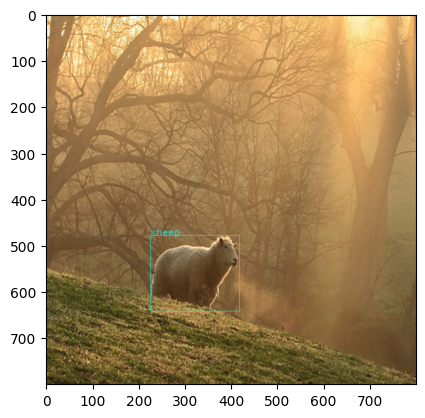

In [53]:
img_np, img_tens, boxes_tens, labels_tens = val_dataset[27]

t = [
    VOCObject(cls=coco_id2label[lbl.item()], xyxy=Box(*box.numpy().astype(int)))
    for box, lbl in zip(boxes_tens, labels_tens)
]
draw_voc_objects(cv2.resize(img_np, (800, 800), interpolation=cv2.INTER_LINEAR), t)

[VOCObject(cls='sheep', xyxy=Box(xmin=219, ymin=486, xmax=423, ymax=632))]


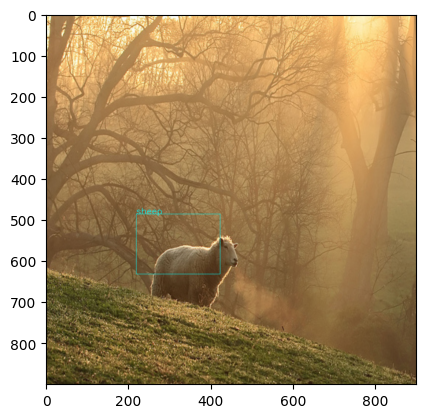

In [54]:
det_res = lightning_fasterRCNN.model(img_tens.unsqueeze(0))
voc_res = postpred2voc_objects(
    fasterrcnn_postprocess(det_res[0], 0.1, 0.1),
    coco_id2label
)

print(voc_res)

draw_voc_objects(img_np, voc_res)

In [37]:
def fasterrcnn_postprocess(results: dict, th: float = 0.1, nms_th: float = 0.1) -> dict:
    well_conf_mask = results['scores'] > th
    nms_indxs = cv2.dnn.NMSBoxes(
        results['boxes'][well_conf_mask].detach().cpu().numpy(),
        results['scores'][well_conf_mask].detach().cpu().numpy(),
        th,
        nms_th
    )
    return {
        'boxes': results['boxes'][well_conf_mask][nms_indxs].detach().cpu().to(torch.int),
        'labels': results['labels'][well_conf_mask][nms_indxs].detach().cpu().to(torch.int),
        'scores': results['scores'][well_conf_mask][nms_indxs].detach().cpu()
    }

In [71]:
fasterrcnn_postprocess(det_res[0], 0.1, 0.1)

{'boxes': tensor([[ 40,  29, 377, 355],
         [735,  32, 907, 347],
         [  4,  10,  86, 212]], dtype=torch.int32),
 'labels': tensor([1, 1, 1], dtype=torch.int32),
 'scores': tensor([0.2333, 0.1538, 0.1436])}

In [38]:
def draw_voc_objects(image: np.array, objects: List[VOCObject]) -> None:
    color = (0, 255, 255)
    image_draw = image.copy()
    for obj in objects:
        tl = (obj.xyxy.xmin, obj.xyxy.ymin)
        br = (obj.xyxy.xmax, obj.xyxy.ymax)        
        cv2.rectangle(image_draw, tl, br, color, 1)
        cv2.putText(
            image_draw, obj.cls, tl,
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 1, cv2.LINE_AA
        )
    plt.imshow(image_draw);

In [39]:
def postpred2voc_objects(post_res: dict, id2label_map: dict) -> List[VOCObject]:
    keys = ['boxes', 'labels']
    return [
        VOCObject(cls=id2label_map[lbl.item()], xyxy=Box(*box.numpy()))
        for box, lbl in zip(*[post_res[k] for k in keys])
    ]

In [59]:
import time
from torchmetrics.detection import MeanAveragePrecision
from tqdm.notebook import tqdm


def eval_frcnn_on_voc(model, dataset, device: str = None):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    model.to(device)
    map = MeanAveragePrecision(iou_type='bbox')
    eval_time_sec = []
    for i in tqdm(range(len(dataset))):
        img_tens, boxes_tens, labels_tens = dataset[i]
        st = time.time()
        res = model(img_tens.unsqueeze(0).to(device))
        et = time.time()
        eval_time_sec.append(et - st)
        preds = [fasterrcnn_postprocess(res[0], 0.1, 0.1)]
        targets = [{'boxes': boxes_tens, 'labels': labels_tens}]
        map.update(preds, targets)
    return map.compute(), round(sum(eval_time_sec) / len(eval_time_sec), 3)

In [51]:
# resnet50_frrcnn = ResnetFasterRCNN('resnet50')

# resnet50_frcnn_checkpoint = torch.load('./resnet_18_distilation_checkpoints/resnet50_07-10-2023-stable.pt')
# resnet50_frrcnn.load_state_dict(resnet50_frcnn_checkpoint['model_state_dict'])

In [62]:
map, avg_time = eval_frcnn_on_voc(lightning_fasterRCNN.model, val_dataset)

  0%|          | 0/5823 [00:00<?, ?it/s]

In [64]:
# обученный на дистиляции resnet18:

In [63]:
map, avg_time

({'map': tensor(0.0793),
  'map_50': tensor(0.1658),
  'map_75': tensor(0.0659),
  'map_small': tensor(0.0032),
  'map_medium': tensor(0.0198),
  'map_large': tensor(0.0910),
  'mar_1': tensor(0.1184),
  'mar_10': tensor(0.1298),
  'mar_100': tensor(0.1298),
  'mar_small': tensor(0.0079),
  'mar_medium': tensor(0.0348),
  'mar_large': tensor(0.1457),
  'map_per_class': tensor(-1.),
  'mar_100_per_class': tensor(-1.),
  'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 16, 17, 18, 19, 20, 21, 44, 62, 63,
          64, 65, 67, 72, 82], dtype=torch.int32)},
 0.104)

In [1]:
# обученный resnet50:

In [101]:
map, avg_time

({'map': tensor(0.2845),
  'map_50': tensor(0.4204),
  'map_75': tensor(0.3209),
  'map_small': tensor(0.0059),
  'map_medium': tensor(0.0876),
  'map_large': tensor(0.3209),
  'mar_1': tensor(0.2870),
  'mar_10': tensor(0.3210),
  'mar_100': tensor(0.3210),
  'mar_small': tensor(0.0070),
  'mar_medium': tensor(0.1049),
  'mar_large': tensor(0.3593),
  'map_per_class': tensor(-1.),
  'mar_100_per_class': tensor(-1.),
  'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 16, 17, 18, 19, 20, 21, 25, 38, 44,
          47, 62, 63, 64, 67, 72, 75, 85, 86], dtype=torch.int32)},
 0.101)